<a href="https://colab.research.google.com/github/bhavin250495/Tensorflow2.0-Tutorial/blob/master/GAN_TF_2_0_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.1

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LeakyReLU,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD

import numpy as np
import matplotlib.pyplot as plt
import os,sys


In [14]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

# Make the data centered around -1 and 1
x_train = x_train/255 * 2 - 1
x_test = x_test/255 * 2 - 1

x_test.shape,x_train.shape

((10000, 28, 28), (60000, 28, 28))

In [15]:
#Flatten the data
N,H,W = x_train.shape
D = H * W
x_train = x_train.reshape(-1,D)
x_test = x_test.reshape(-1,D)
x_test.shape,x_train.shape

((10000, 784), (60000, 784))

In [0]:
#Dimensionality of latent space
latent_dim = 100

In [0]:
# get generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256,activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512,activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D,activation='tanh')(x)
  model = Model(i,x)
  return model

In [0]:
# get descriminator model
def build_descriminator(image_size):
  i = Input(shape=(image_size,))
  x = Dense(512,activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256,activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1,activation='sigmoid')(x)
  model = Model(i,x)
  return model


In [0]:
#build and compile discriminator
discriminator = build_descriminator(D)

discriminator.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(0.0002,0.5),
    metrics = ['acc']
)


#build and compile combined model
generator = build_generator(latent_dim)

#create an input to represent noise sample from latent space
z = Input(shape = (latent_dim,))

#Pass noise through generator to get image
img = generator(z)

#only generator will be trained
discriminator.trainable = False

fake_pred = discriminator(img)

#create combined model
combined_model = Model(z,fake_pred)

#compile the combined model
combined_model.compile(loss = 'binary_crossentropy',optimizer = Adam(0.0002,0.5))





In [0]:
#config
batch_size = 32
epochs = 30000
sample_period = 200 #every sample steps generate and save data

#create batch label for train on batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

#store the loss
d_losses = []
g_losses = []

#store generated images in folder
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')



In [0]:
def sample_images(epoch):
  rows,cols = 5,5
  noise = np.random.randn(rows*cols,latent_dim)
  imgs = generator.predict(noise)

  #rescale the images to be between 0 - 1r
  imgs = 0.5 * imgs + 0.5

  fig,axs = plt.subplots(rows,cols)
 
  idx = 0 
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W),cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  
  fig.savefig('gan_images/%d.png' % epoch)
  plt.close()




In [0]:
for epoch in range(epochs):

  ####Train Discriminator####

  #select random batch of images
  idx = np.random.randint(0,x_train.shape[0],batch_size)
  real_imgs = x_train[idx]

  #generate fake images
  noise = np.random.randn(batch_size,latent_dim)
  fake_imgs = generator.predict(noise)
  
  #Train discriminator
  d_loss_real,d_acc_real = discriminator.train_on_batch(real_imgs,ones)
  d_loss_fake,d_acc_fake = discriminator.train_on_batch(fake_imgs,zeros)

  #overall mean of loss and acc
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  ####Train Generator####

  noise = np.random.randn(batch_size,latent_dim)
  g_loss = combined_model.train_on_batch(noise,ones)

  #save loss
  d_losses.append(d_loss) 
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f'epoch: {epoch + 1}/ {epochs}, d_loss: {d_loss:.2f},d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}')
  if epoch % sample_period == 0 :
    print(epoch)
    sample_images(epoch)




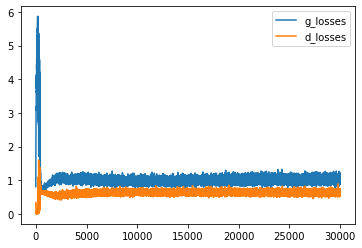

In [72]:
plt.plot(g_losses,label='g_losses')
plt.plot(d_losses,label='d_losses')
plt.legend()

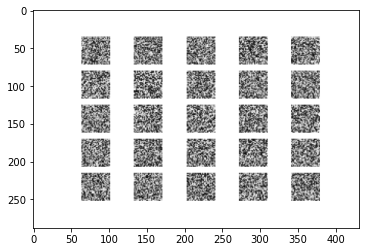

In [73]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

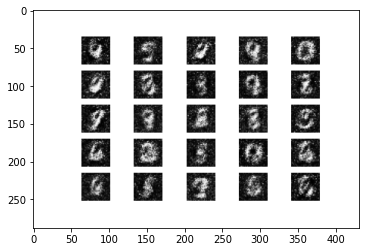

In [75]:
from skimage.io import imread
a = imread('gan_images/1000.png')
plt.imshow(a)

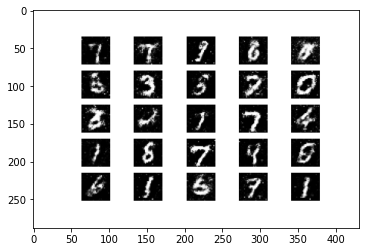

In [76]:
from skimage.io import imread
a = imread('gan_images/5000.png')
plt.imshow(a)

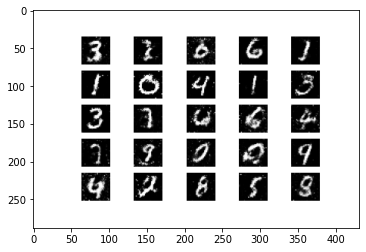

In [77]:
from skimage.io import imread
a = imread('gan_images/10000.png')
plt.imshow(a)

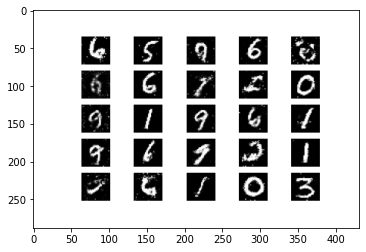

In [78]:
from skimage.io import imread
a = imread('gan_images/20000.png')
plt.imshow(a)

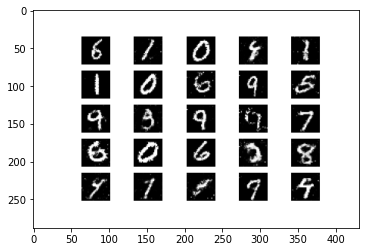

In [79]:
from skimage.io import imread
a = imread('gan_images/29800.png')
plt.imshow(a)